<a href="https://colab.research.google.com/github/lorrespz/NLP-Text-Analyses/blob/main/Text_Classification_with_Custom_CNNs_%5BPyTorch%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spam detection with Custom CNNs [PyTorch]

This is from Lazy Programmer's PyTorch course.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Load dataset for spam detection

In [3]:
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

--2024-03-10 07:35:16--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.03s   

2024-03-10 07:35:16 (17.9 MB/s) - ‘spam.csv’ saved [503663/503663]



In [4]:
df = pd.read_csv('spam.csv', encoding = 'ISO-8859-1')

In [5]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [6]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)

In [10]:
#Rename columns
df.columns = ['label','data']

In [11]:
df.head()

,label,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
df['target'] = df['label'].map({'ham': 0, 'spam': 1})

In [13]:
df.head()

,label,data,target
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [16]:
#TRAIN TEST SPLIT
df_train, df_test = train_test_split(df, test_size = 0.33, shuffle = True)
df_train.shape, df_test.shape

((3733, 3), (1839, 3))

# Tokenizing, converting tokens to integers

In [17]:
idx = 1
word2idx = {'<PAD>': 0}

for i, row in df_train.iterrows():
  tokens = row['data'].lower().split()
  for token in tokens:
    if token not in word2idx:
      word2idx[token] = idx
      idx+=1

In [18]:
word2idx

{'<PAD>': 0,
 'pls': 1,
 'call': 2,
 'me': 3,
 'da.': 4,
 'what': 5,
 'happen.': 6,
 'maybe': 7,
 'you': 8,
 'should': 9,
 'find': 10,
 'something': 11,
 'else': 12,
 'to': 13,
 'do': 14,
 'instead???': 15,
 'k.i': 16,
 "did't": 17,
 'see': 18,
 'you.:)k:)where': 19,
 'are': 20,
 'now?': 21,
 "i'm": 22,
 'not': 23,
 'workin.': 24,
 'once': 25,
 'i': 26,
 'get': 27,
 'job...': 28,
 '\\alright': 29,
 'babe': 30,
 'hope': 31,
 'having': 32,
 'a': 33,
 'great': 34,
 'day.': 35,
 'tiwary': 36,
 'rcb.battle': 37,
 'between': 38,
 'bang': 39,
 'and': 40,
 'kochi.': 41,
 'sorry,': 42,
 "i'll": 43,
 'later': 44,
 'hanks': 45,
 'lotsly!': 46,
 'er': 47,
 'yeah,': 48,
 'will': 49,
 'b': 50,
 'there': 51,
 'at': 52,
 '15:26,': 53,
 'sorry!': 54,
 'just': 55,
 'tell': 56,
 'which': 57,
 'pub/cafe': 58,
 'sit': 59,
 'in': 60,
 'come': 61,
 'wen': 62,
 'u': 63,
 'can': 64,
 'said': 65,
 'its': 66,
 'okay.': 67,
 'sorry': 68,
 'so': 69,
 'did': 70,
 'the': 71,
 'bank': 72,
 'say': 73,
 'about': 74,
 '

In [20]:
# CREATE TRAIN DATA
train_sentences_as_int = []
for i, row in df_train.iterrows():
  tokens = row['data'].lower().split()
  sentence_as_int = [word2idx[token] for token in tokens]
  train_sentences_as_int.append(sentence_as_int)

In [21]:
#CREATE TEST DATA
test_sentences_as_int = []
for i, row in df_test.iterrows():
  tokens = row['data'].lower().split()
  sentence_as_int = [word2idx[token] for token in tokens if token in word2idx]
  test_sentences_as_int.append(sentence_as_int)

In [22]:
len(train_sentences_as_int), len(test_sentences_as_int)

(3733, 1839)

# Custom Data Generator

In [23]:
def data_generator(X, y, bs = 32):
  X, y = shuffle(X, y)
  n_batches = int(np.ceil(len(y)/bs))
  for i in range(n_batches):
    end = min((i+1)*bs, len(y))

    X_batch = X[i*bs:end]
    y_batch = y[i*bs:end]
    #pad X_batch to be NxT
    max_len = np.max([len(x) for x in X_batch])
    for j in range(len(X_batch)):
      x = X_batch[j]
      pad = [0]*(max_len - len(x))
      X_batch[j] = pad + x

    X_batch = torch.from_numpy(np.array(X_batch))
    y_batch = torch.from_numpy(np.array(y_batch))

    yield X_batch, y_batch


# Build custom CNN model

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [27]:
# Shape of the embedding output is NxTxD
embed = nn.Embedding(len(word2idx), 20)
for inputs, targets in data_generator(train_sentences_as_int, df_train.target):
  out = embed(inputs)
  print('Input shape:', inputs.shape)
  print('Output shape:', out.shape)
  break

Input shape: torch.Size([32, 71])
Output shape: torch.Size([32, 71, 20])


The nn.Conv1d layer takes in the shape NxDxT, not NxTxD like the output of the embedding layer, so we need to reshape the output data after going through the embedding layer.

In [28]:
# DEFINE THE MODEL
class CNN(nn.Module):
  def __init__(self, n_vocab, embed_dim, n_outputs):
    super(CNN, self).__init__()
    self.V = n_vocab
    self.D = embed_dim
    self.K = n_outputs

    #Dimension of Embedding layer is VxD
    #if the input is T word integer, the output is TxD
    #batch input: NxT, batch output NxTxD
    self.embed = nn.Embedding(self.V, self.D)

    #Conv layers: Input NxDxT, not NxTxD
    self.conv1 = nn.Conv1d(self.D, 32, 3, padding = 1)
    self.pool1 = nn.MaxPool1d(2)
    self.conv2 = nn.Conv1d(32, 64, 3, padding = 1)
    self.pool2 = nn.MaxPool1d(2)
    self.conv3 = nn.Conv1d(64, 128, 3, padding = 1)

    self.fc  = nn.Linear(128, self. K)

  def forward(self, X):
    out = self.embed(X)
    #out is NxTxD

    #in is NxDxT, so need to permute the output
    out = out.permute(0,2,1)
    out = self.conv1(out)
    out = F.relu(out)
    out = self.pool1(out)
    out = self.conv2(out)
    out = F.relu(out)
    out = self.pool2(out)
    out = self.conv3(out)
    out = F.relu(out)

    #change it back to get NxTxD
    out = out.permute(0,2,1)

    # max pool
    out, _ = torch.max(out, 1)

    #final dense layer
    out = self.fc(out)
    return out

In [29]:
#Instantiate the model
model = CNN(len(word2idx), 20, 1)
model.to(device)

CNN(
  (embed): Embedding(10575, 20)
  (conv1): Conv1d(20, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [30]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

# Train model

In [31]:
train_gen = lambda: data_generator(train_sentences_as_int, df_train.target)
test_gen = lambda: data_generator(test_sentences_as_int, df_test.target)


In [32]:
def batch_gd(model, criterion, optimizer, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for i in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for input, target in train_gen():
      target = target.view(-1,1).float()
      input, target = input.to(device), target.to(device)

      optimizer.zero_grad()
      out = model(input)
      loss = criterion(out, target)
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
    train_loss = np.mean(train_loss)

    test_loss = []
    for input, target in test_gen():
      target = target.view(-1,1).float()
      input, target = input.to(device), target.to(device)
      out = model(input)
      loss = criterion(out, target)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    train_losses[i] = train_loss
    test_losses[i] = test_loss

    dt = datetime.now()-t0
    print(f'Epoch: {i+1}/{epochs}, train loss: {train_loss: .4f}\
          test_loss: {test_loss: .4f}, duration: {dt}')
  return train_losses, test_losses


In [33]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, epochs=8)

Epoch: 1/8, train loss:  0.3911          test_loss:  0.3242, duration: 0:00:01.200621
Epoch: 2/8, train loss:  0.2234          test_loss:  0.1695, duration: 0:00:00.836782
Epoch: 3/8, train loss:  0.1348          test_loss:  0.1229, duration: 0:00:00.843845
Epoch: 4/8, train loss:  0.0927          test_loss:  0.1115, duration: 0:00:01.144051
Epoch: 5/8, train loss:  0.0700          test_loss:  0.1028, duration: 0:00:01.438003
Epoch: 6/8, train loss:  0.0546          test_loss:  0.0993, duration: 0:00:02.025484
Epoch: 7/8, train loss:  0.0412          test_loss:  0.0882, duration: 0:00:01.756198
Epoch: 8/8, train loss:  0.0307          test_loss:  0.0877, duration: 0:00:02.010938


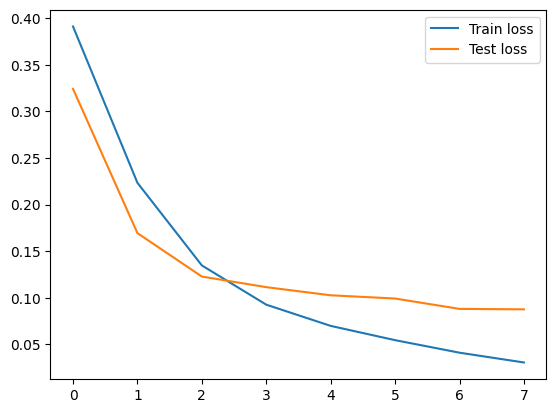

In [34]:
plt.plot(train_losses, label = 'Train loss')
plt.plot(test_losses, label = 'Test loss')
plt.legend()
plt.show()

# Accuracy

In [39]:
def calc_acc(data_gen, model):
  n_corr = 0
  n_tot = 0

  for input, target in data_gen:
    target = target.view(-1,1).float()
    input, target = input.to(device), target.to(device)

    out = model(input)
    pred = (out >0)
    n_corr +=(pred == target).sum().item()
    n_tot +=target.shape[0]

    acc = n_corr/n_tot

    return acc


In [41]:
train_acc = calc_acc(train_gen(), model)
test_acc = calc_acc(test_gen(), model)
print(f'Train accuracy:, {train_acc:.4f}, Test accuracy:, {test_acc:.4f}')

Train accuracy:, 1.0000, Test accuracy:, 1.0000
